In [1]:
import random
import torchvision
import torch
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm.notebook import tqdm
import os
import zipfile
from PIL import Image
from collections import defaultdict
import copy
from torch.nn import ReLU, Conv2d, BatchNorm2d, Sequential, AdaptiveAvgPool2d, Linear, MaxPool2d, Flatten, CrossEntropyLoss, PReLU, InstanceNorm2d, LeakyReLU, AvgPool2d
try:
    import pytorch_lightning as pl
except:
    !pip install pytorch-lightning
    import pytorch_lightning as pl
try:
    import adabelief_pytorch
except:
    !pip install adabelief_pytorch==0.2.0
    time.sleep(1)
    import adabelief_pytorch

"""if not os.path.exists("drive"):
    from google.colab import drive
    drive.mount('/content/drive')"""

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # We'd like to use GPU
device

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.4/716.4 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 29.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


device(type='cuda', index=0)

In [2]:
class SynthesizedImage(torch.nn.Module):
    def __init__(self, img, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = torch.nn.Parameter(img)

    def forward(self):
        return self.weight

In [15]:
class EmptyDataset:
    def __init__(self):
        self.data = [torch.tensor([1., ]), ]

    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)

In [16]:
class StylingModule(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self._config = config

        self.content_layers = config['content_layers']
        self.style_layers = config['style_layers']
        self.rgb_mean = config['rgb_mean']
        self.rgb_std = config['rgb_std']
        self.content_weight, self.style_weight, self.tv_weight = config['weights']
        self._make_net()

        self.content_img = torchvision.io.read_image(config['content_img_path']).float()/255.
        self.content_img = self.content_img.to(device)
        self.style_img = torchvision.io.read_image(config['style_img_path']).float()/255.
        self.style_img = self.style_img.to(device)

        self.content_X, self.contents_Y = self.get_contents()
        self.style_X, self.styles_Y = self.get_styles()
        self.styles_Y_gram = list(StylingModule.gram(style_Y) for style_Y in self.styles_Y)

        img = torchvision.io.read_image(config['content_img_path']).float()/255.
        img = img.to(device)
        self.gen_img = SynthesizedImage(self.preprocess(img))
        self.gen_img.to(device)
        self.X = self.gen_img()

    def train_dataloader(self):
        return torch.utils.data.DataLoader(EmptyDataset(), batch_size=1)

    def configure_optimizers(self):
        opt_class = config['opt_class']
        opt_params = config['opt_params']
        optimizer = opt_class(self.gen_img.parameters(), **opt_params)
        return {'optimizer':optimizer, 'lr_scheduler':torch.optim.lr_scheduler.StepLR(optimizer, 50, 0.8)}

    def preprocess(self, img):
        transforms = torchvision.transforms.Compose([
            torchvision.transforms.Normalize(mean=self.rgb_mean, std=self.rgb_std)])
        return transforms(img).unsqueeze(0)

    def _make_net(self):
        pretrained_net = torchvision.models.vgg19(weights='DEFAULT', progress=False).requires_grad_(False).to(device)
        self.net = torch.nn.Sequential(*[pretrained_net.features[i] for i in
                      range(max(self.content_layers + self.style_layers) + 1)])
        
    def extract_features(self, X):
        contents = []
        styles = []
        for i, block in enumerate(self.net):
            X = block(X)
            if i in self.style_layers:
                styles.append(X)
            if i in self.content_layers:
                contents.append(X)
        return contents, styles
        
    def get_contents(self):
        content_X = self.preprocess(self.content_img)
        contents_Y, _ = self.extract_features(content_X)
        return content_X, contents_Y

    def get_styles(self):
        style_X = self.preprocess(self.style_img)
        _, styles_Y = self.extract_features(style_X)
        return style_X, styles_Y

    def gram(X):
        num_channels, n = X.shape[1], X.numel() // X.shape[1]
        X = X.reshape((num_channels, n))
        return torch.matmul(X, X.T) / (num_channels * n)

    def content_loss(Y_hat, Y):
        # We detach the target content from the tree used to dynamically compute
        # the gradient: this is a stated value, not a variable. Otherwise the loss
        # will throw an error.
        return torch.square(Y_hat - Y.detach()).mean()

    def style_loss(Y_hat, gram_Y):
        return torch.square(StylingModule.gram(Y_hat) - gram_Y.detach()).mean()

    def tv_loss(Y_hat):
        return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                    torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

    def compute_loss(self, X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
        # Calculate the content, style, and total variance losses respectively
        contents_l = [StylingModule.content_loss(Y_hat, Y) * self.content_weight for Y_hat, Y in zip(
            contents_Y_hat, contents_Y)]
        styles_l = [StylingModule.style_loss(Y_hat, Y) * self.style_weight for Y_hat, Y in zip(
            styles_Y_hat, styles_Y_gram)]
        tv_l = StylingModule.tv_loss(X) * self.tv_weight
        # Add up all the losses
        l = sum(styles_l + contents_l + [tv_l])
        return contents_l, styles_l, tv_l, l

    def training_step(self, batch, batch_idx):
        contents_Y_hat, styles_Y_hat = self.extract_features(self.X)
        contents_l, styles_l, tv_l, l = self.compute_loss(
            self.X, contents_Y_hat, styles_Y_hat, self.contents_Y, self.styles_Y_gram)
        
        return {"loss": l}

In [24]:
config = {
    'style_layers' : [0, 5, 10, 19, 28],
    'content_layers' : [25, ],
    'opt_class' : torch.optim.Adam,
    'opt_params' : {'lr':0.3},
    'content_img_path' : 'c.jpg',
    'style_img_path' : 'S2.jpg',
    'weights' : [1, 1e4, 10],
    'rgb_mean' : (0.485, 0.456, 0.406),
    'rgb_std' : (0.229, 0.224, 0.225)
}

In [25]:
module = StylingModule(config)

In [26]:
logger = pl.loggers.TensorBoardLogger("./logs", name='style_transfer')
trainer = pl.Trainer(
    accelerator="gpu",
    logger=logger,
    log_every_n_steps=1,
    max_epochs=300)
trainer.fit(module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params
---------------------------------------------
0 | net     | Sequential       | 12.9 M
1 | gen_img | SynthesizedImage | 1.3 M 
---------------------------------------------
1.3 M     Trainable params
12.9 M    Non-trainable params
14.2 M    Total params
56.897    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.


In [27]:
module.X.shape

torch.Size([1, 3, 533, 800])

tensor(1.3110)
tensor(-0.4561)


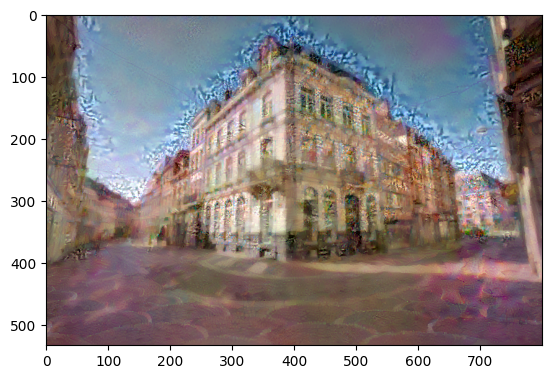

In [28]:
img = torch.clone(module.X).detach().cpu()
img *= torch.tensor((0.229, 0.224, 0.225)).reshape(1, 3, 1, 1)
img += torch.tensor((0.485, 0.456, 0.406)).reshape(1, 3, 1, 1)
plt.figure()
print(img.max())
print(img.min())
plt.imshow(img[0].permute(1, 2, 0))
plt.show()

In [272]:
def gram(x):
    # get the batch size, channels, height, and width of the image
    (bs, ch, h, w) = x.size()
    f = x.view(bs, ch, w * h)
    G = f.bmm(f.transpose(1, 2)) / (ch * h * w)
    return G

class StyleLoss(torch.nn.Module):
    def __init__(self, style_weight, style_features):
        super(StyleLoss, self).__init__()
        self.style_gram = gram(style_features).detach()
        self.style_weight = style_weight

    def forward(self, input):
        input_g = gram(input)
        loss = self.style_weight * torch.nn.functional.mse_loss(input_g, self.style_gram)
        return loss

class ContentLoss(torch.nn.Module):
    def __init__(self, content_weight, content_features):
        super(ContentLoss, self).__init__()
        self.content_weight = content_weight
        self.content_features = content_features.detach()

    def forward(self, input):
        loss = self.content_weight * torch.nn.functional.mse_loss(input, self.content_features)
        return loss

In [289]:
class StyleModule:
    def __init__(self, config):
        self._config = config
        self.init_transform = config['init_transform']
        self.device = config['device']
        torch.autograd.set_detect_anomaly(True)

        self.style = self.open_img(config['style_path']).requires_grad_(False)
        self.content = self.open_img(config['content_path']).requires_grad_(False)
        self.input = self.open_img(config['content_path'], transform=False).requires_grad_(True)

        self.model = torchvision.models.resnet34(weights=torchvision.models.ResNet34_Weights.DEFAULT).requires_grad_(False).to(self.device)
        self.module_list = [self.model.conv1,
                            self.model.bn1,
                            self.model.relu,
                            self.model.maxpool,
                            self.model.layer1,
                            self.model.layer2,
                            self.model.layer3,
                            self.model.layer4]

        self.content_layers = config['content_layers']
        self.style_layers = config['style_layers']

        self.content_features = self.make_features(self.content, self.content_layers)
        self.style_features = self.make_features(self.style, self.style_layers)

        self.style_losses = list(StyleLoss(config['style_weight'], style_feature) for style_feature in self.style_features)
        self.content_losses = list(ContentLoss(config['content_weight'], content_feature) for content_feature in self.content_features)

        self.configure_optimizers()

    def open_img(self, path, transform=True):
        img = torchvision.io.read_image(path).float() / 255.
        if transform:
            img = self.init_transform(img)
        img = img.reshape(1, *img.shape)
        img = img.to(self.device)
        return img

    def make_features(self, input, layers_num):
        prev_layer_num = 0
        feature_list = []
        feature = input
        for layer_num in layers_num:
            for module in self.module_list[prev_layer_num:layer_num]:
                feature = module(feature)
            feature_list.append(feature)
            prev_layer_num = layer_num
        return feature_list

    def configure_optimizers(self):
        opt_class = self._config['opt_class']
        opt_params = self._config['opt_params']
        optimizer = opt_class([self.input,], **opt_params)
        self.optimizer = optimizer

    def train_step(self):
        self.input = torch.clamp(self.input, 0, 1)
        self.input.grad = None
        img = self.input - torch.tensor((0.485, 0.456, 0.406)).reshape(1, 3, 1, 1).to(device)
        img /= torch.tensor((0.229, 0.224, 0.225)).reshape(1, 3, 1, 1).to(device)

        input_features_for_content = self.make_features(img, self.content_layers)
        input_features_for_style = self.make_features(img, self.style_layers)
        
        loss = 0
        for c_feature, c_loss in zip(input_features_for_content, self.content_losses):
            loss += c_loss(c_feature)
        for s_feature, s_loss in zip(input_features_for_style, self.style_losses):
            loss += s_loss(s_feature)
        grad = torch.autograd.grad(loss, self.input)[0]
        print(grad.max())
        print(grad.min())
        self.input -= grad*1000

        return  loss.item()

    def train(self):
        with tqdm(total=self._config['num_epochs']) as pbar:
            for _ in range(self._config['num_epochs']):
                loss = self.train_step()
                pbar.update()
                pbar.set_postfix({'loss' : loss})

In [290]:
config = {
    'style_weight' : 10000.0,
    'content_weight' : 1.,
    'init_transform' : torchvision.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    'opt_class' : torch.optim.Adam,
    'opt_params' : {
        'lr' : 5e-3,
        'betas' : (0.8, 0.999)
    },
    'num_epochs' : 50,
    'device' : device,
    'style_path' : 'd0450f9603254e299d0ad3220789f1db.jpg',
    'content_path' : '1597214538_3.jpg',
    'style_layers' : [4, 5, 6, 7],
    'content_layers' : [6, ]
}

In [291]:
module = StyleModule(config)

In [292]:
module.train()

  0%|          | 0/50 [00:00<?, ?it/s]

tensor(7.5441e-06)
tensor(-7.7292e-06)
tensor(0.0001)
tensor(-0.0001)
tensor(0.0002)
tensor(-0.0002)
tensor(9.6365e-05)
tensor(-0.0001)
tensor(9.9031e-05)
tensor(-0.0001)


KeyboardInterrupt: ignored

torch.Size([3, 533, 800])


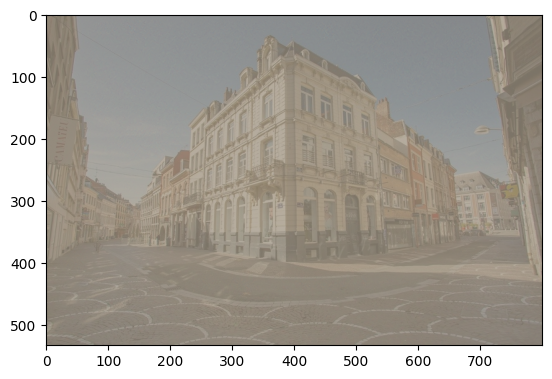

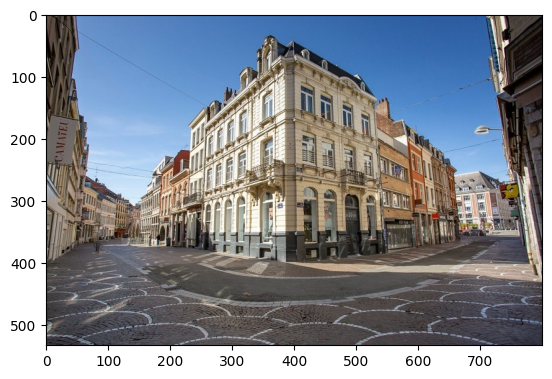

In [293]:
img = module.input.detach()[0]
img = img.cpu()
mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
img = img*std + mean
print(img.shape)
plt.figure()
plt.imshow(img.permute(1, 2, 0))
plt.show()
plt.figure()
plt.imshow(torchvision.io.read_image('1597214538_3.jpg').permute(1, 2, 0))
plt.show()